## 1. Introduction to spaCy

### 1.1 Documents, spans and tokens

In [3]:
import spacy

# Create a blank English nlp object
nlp = spacy.blank ("en")

# Created by processing a string of text with the nlp oject
doc = nlp("Hello world!")

# Iterate over tokens in a Doc
for token in doc:
    print(token.text)

# Index into the Doc to get a single Token
token = doc[1]

# Get the token text via the .text attribute
print(token.text)

# A slice from the Doc is a Span object
span = doc[1:3]

# Get the span text via the .text attributes
print(span.text)

Hello
world
!
world
world!


### 1.2 Lexical attributes

In [4]:
doc = nlp("It costs $5.")
print("Index:", [token.i for token in doc])
print("Text:", [token.text for token in doc])

print("is_alpha:", [token.is_alpha for token in doc])
print("is_punct:", [token.is_punct for token in doc])
print("like_num:", [token.like_num for token in doc])

Index: [0, 1, 2, 3, 4]
Text: ['It', 'costs', '$', '5', '.']
is_alpha: [True, True, False, False, False]
is_punct: [False, False, False, False, True]
like_num: [False, False, False, True, False]


### 1.3 Pipelines

In [5]:
import spacy

# load the small English pipeline
nlp = spacy.load("en_core_web_sm") # this package provide Binary weights & vocabulary & Meta information & Configuration file

# Process a text
doc = nlp("She ate the pizza")

# Iterate over the tokens
for token in doc:
    # Print the text and the predicted part-of-speech tag
    print(token.text, token.pos_)


print("\n#### Predicting Syntactic Dependencies ####")
## Predicting Syntactic Dependencies
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

print("\n#### Preidcting Named Entities ####")
# Process a text
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

# Iterate over the predicted entities
for ent in doc.ents:
    # Print the entity text and its label
    print(ent.text, ent.label_)

print("\n#### Tip: the spacy.explain method ####")
spacy.explain("GPE")
spacy.explain("NNP")
spacy.explain("dobj")

She PRON
ate VERB
the DET
pizza NOUN

#### Predicting Syntactic Dependencies ####
She PRON nsubj ate
ate VERB ROOT ate
the DET det pizza
pizza NOUN dobj ate

#### Preidcting Named Entities ####
Apple ORG
U.K. GPE
$1 billion MONEY

#### Tip: the spacy.explain method ####


'direct object'

### 1.4. Rule-based matching

Why not just regular expressions?

- Math on `Doc` objects, not just strings
- Match on tokens and token attributes
- Use a model's predictions
- Example: "duck" (verb) vs. "duck" (noun)

Match patterns
- List of dictionaries, one per token
- Match exact token texts 
[{"TEXT": "iPhone"}, {"Text": "x"}]
- Match lexical attribtes
[{"LOWER": "iphone"}, {"LOWER": "x"}]
- Match any token attributes
[{"LEMMA": "buy"}, {"POS": "NOUN"}]

In [6]:
import spacy

# Import the Matcher
from spacy.matcher import Matcher

# Load a pipeline and create the nlp object
nlp = spacy.load("en_core_web_sm")

# Initialize the matcher with the shared vocab
matcher = Matcher(nlp.vocab)

# Add the pattern to the matcher
pattern = [{"TEXT": "iPhone"}, {"TEXT": "X"}]
matcher.add("IPHONE_PATTERN", [pattern])

# Process some text
doc = nlp("Upcoming iPhone X release date leaked")

# Call the matcher on the doc
matches = matcher(doc)

# Iterate over the matches
for match_id, start, end in matches:
    # Get the matched span
    matched_span = doc[start:end]
    print(matched_span.text)


###
print("#### Matching lexical attributes ####")
pattern = [
    {"IS_DIGIT": True},
    {"LOWER": "fifa"},
    {"LOWER": "world"},
    {"LOWER": "cup"},
    {"IS_PUNCT": True}
]
doc = nlp("2018 FIFA World Cup: France won!")
print("Matches:", [doc[start:end].text for match_id, start, end in matches])

print("#### Matching other token attributes ####")
pattern = [
    {"LEMMA": "love", "POS": "VERB"},
    {"POS": "NOUN"}
]
doc = nlp("I loved dogs but now I love cats more.")
print("Matches:", [doc[start:end].text for match_id, start, end in matches])

print("#### Using operators and quantifiers ####")
pattern = [
    {"LEMMA": "buy"},
    {"POS": "DET", "OP": "?"},  # optional: match 0 or 1 times 
    
# "OP" can have one of four values:

# An "!" negates the token, so it's matched 0 times.

# A "?" makes the token optional, and matches it 0 or 1 times.

# A "+" matches a token 1 or more times.

# And finally, an "*" matches 0 or more times.

    {"POS": "NOUN"}
]

# # Write a pattern for adjective plus one or two nouns
# pattern = [{"POS": "ADJ"}, {"POS": "NOUN"}, {"POS": "NOUN", "OP": "?"}]

doc = nlp("I bought a smartphone. Now I'm buying apps.")
print("Matches:", [doc[start:end].text for match_id, start, end in matches])

iPhone X
#### Matching lexical attributes ####
Matches: ['FIFA World']
#### Matching other token attributes ####
Matches: ['loved dogs']
#### Using operators and quantifiers ####
Matches: ['bought a']


## 2. Large-scale data analysis with spaCy
### 2.1 Data structures (1) Vocab, Lexemes, and StringStore
- `Vocab`: stores data shared across multiple documents
- To save memory, spaCy encodes all strings to hash values
- Strings are only stored once in the `StringStore` via `nlp.vocab.strings`
- String store: **lookup table** in both directionsb

In [7]:
nlp.vocab.strings.add("coffee")
coffee_hash = nlp.vocab.strings["coffee"]
coffee_string = nlp.vocab.strings[coffee_hash]
print(coffee_hash, coffee_string)
# Hashes can't be reversed – that's why we need to provide the shared vocab
# Raises an error if we haven't seen the string before
string = nlp.vocab.strings[3197928453018144401]

# Look up the string and hash in nlp.vocab.strings
doc = nlp("I love coffee")
print("hash value:", nlp.vocab.strings["coffee"])
print("string value:", nlp.vocab.strings[3197928453018144401])

# The doc also exposes the vocab and strings
doc = nlp("I love coffee")
print("hash value:", doc.vocab.strings["coffee"])

3197928453018144401 coffee


##### Lexemes: entries in the vocabulary
- A `lexeme` object is an entry in the vocabulary
- Contains the **context-independent** information about a word
- Word text: `lexeme.text` and `lexeme.orth` (the hash)
- Lexical attributes like `lexeme.is_alpha`
- Not context-dependent part-of-speech tags, dependencies or entity labels

In [8]:
doc = nlp("I love coffee")
lexeme = nlp.vocab["coffee"]

# Print the lexical attributes
print(lexeme.text, lexeme.orth, lexeme.is_alpha)


coffee 3197928453018144401 True


#### 2.2 Data structures (2): Doc, Span and Token

- `Doc` and `Span` are very powerful and hold references and relationships of words and sentences
- **Convert result to strings as late as possible**
- **Use token attributes if available** – for example, `token.i` for the token index
- Don't forget to pass in the shared `vocab`


In [9]:
# The Doc object
# Create an nlp object
import spacy
nlp = spacy.blank("en")

# Import the Doc class
from spacy.tokens import Doc

# The words and spaces to create the doc from
words = ["Hello", "world", "!"]
spaces = [True, False, False]

# Create a doc manually
doc = Doc(nlp.vocab, words=words, spaces=spaces)
print(doc.text)


# The Span object
# Import the Doc and Span classes
from spacy.tokens import Doc, Span

# The words and spaces to create the doc from
words = ["Hello", "world", "!"]
spaces = [True, False, False]

# Create a doc manually
doc = Doc(nlp.vocab, words=words, spaces=spaces)

# Create a span manually
span = Span(doc, 0, 2)

# Create a span with a label
span_with_label = Span(doc, 0, 2, label="GREETING")

# Add span to the doc.ents
doc.ents = [span_with_label]

# Print entities' text and labels
print([(ent.text, ent.label_) for ent in doc.ents])

Hello world!
[('Hello world', 'GREETING')]


#### 2.3 Word vectors and semantic similarity
**Comparing semantic similarity**
- spaCy can compare two objects and predict similarity
- `Doc.similarity()`, `Span.similarity()` and `Token.similarity()`
- Take another object and return a similarity score (`0` to `1`)
- **Important**: needs a pipeline that has word vectors included, for example:
- ✅ `en_core_web_md` (medium)
- ✅ `en_core_web_lg` (large)
- 🚫 NOT `en_core_web_sm` (small)

In [ ]:
# Similarity examples
# Load a larger pipeline with vectors
nlp = spacy.load("en_core_web_md")

# Compare two documents
doc1 = nlp("I like fast food")
doc2 = nlp("I like pizza")
print(doc1.similarity(doc2))


# Compare two tokens
doc = nlp("I like pizza and pasta")
token1, token2 = doc[2], doc[4]
print(token1.similarity(token2))


# Compare a document with a token
doc = nlp("I like pizza")
token = nlp("soap")[0]

print(doc.similarity(token))


# Compare a span with a document
span = nlp("I like pizza and pasta")[2:5]
doc = nlp("McDonalds sells burgers")

print(span.similarity(doc))

**How does spaCy predict similarity?**
- Similarity is determined using word vectors
- Multi-dimensional meaning representations of words
- Generated using an algorithm like Word2Vec and lots of text
- Can be added to spaCy's pipelines
- Default: cosine similarity, but can be adjusted
- Doc and Span vectors default to average of token vectors
- Short phrases are better than long documents with many irrelevant words

In [10]:
# Load a larger pipeline with vectors
nlp = spacy.load("en_core_web_md")

doc = nlp("I have a banana")
# Access the vector via the token.vector attribute
print(doc[3].vector)

[ 0.20778  -2.4151    0.36605   2.0139   -0.23752  -3.1952   -0.2952
  1.2272   -3.4129   -0.54969   0.32634  -1.0813    0.55626   1.5195
  0.97797  -3.1816   -0.37207  -0.86093   2.1509   -4.0845    0.035405
  3.5702   -0.79413  -1.7025   -1.6371   -3.198    -1.9387    0.91166
  0.85409   1.8039   -1.103    -2.5274    1.6365   -0.82082   1.0278
 -1.705     1.5511   -0.95633  -1.4702   -1.865    -0.19324  -0.49123
  2.2361    2.2119    3.6654    1.7943   -0.20601   1.5483   -1.3964
 -0.50819   2.1288   -2.332     1.3539   -2.1917    1.8923    0.28472
  0.54285   1.2309    0.26027   1.9542    1.1739   -0.40348   3.2028
  0.75381  -2.7179   -1.3587   -1.1965   -2.0923    2.2855   -0.3058
 -0.63174   0.70083   0.16899   1.2325    0.97006  -0.23356  -2.094
 -1.737     3.6075   -1.511    -0.9135    0.53878   0.49268   0.44751
  0.6315    1.4963    4.1725    2.1961   -1.2409    0.4214    2.9678
  1.841     3.0133   -4.4652    0.96521  -0.29787   4.3386   -1.2527
 -1.7734   -3.5637   -0.20035

**Similarity depends on the application context**
- Useful for many applications: recommendation systems, flagging duplicates etc.
- There's no objective definition of "similarity"
- Depends on the context and what application needs to do

In [11]:
doc1 = nlp("I like cats")
doc2 = nlp("I hate cats")

print(doc1.similarity(doc2))

0.9530093158841214


**Combiing predictions and rules**


In [12]:
# Initialize with the shared vocab
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

# Patterns are lists of dictionaries describing the tokens
pattern = [{"LEMMA": "love", "POS": "VERB"}, {"LOWER": "cats"}]
matcher.add("LOVE_CATS", [pattern])

# Operators can specify how often a token should be matched
pattern = [{"TEXT": "very", "OP": "+"}, {"TEXT": "happy"}]
matcher.add("VERY_HAPPY", [pattern])

# Calling matcher on doc returns list of (match_id, start, end) tuples
doc = nlp("I love cats and I'm very very happy")
matches = matcher(doc)

# Adding statistical predictions
matcher = Matcher(nlp.vocab)
matcher.add("DOG", [[{"LOWER": "golden"}, {"LOWER": "retriever"}]])
doc = nlp("I have a Golden Retriever")

for match_id, start, end in matcher(doc):
    span = doc[start:end]
    print("Matched span:", span.text)
    # Get the span's root token and root head token
    print("Root token:", span.root.text)
    print("Root head token:", span.root.head.text)
    # Get the previous token and its POS tag
    print("Previous token:", doc[start - 1].text, doc[start - 1].pos_)

Matched span: Golden Retriever
Root token: Retriever
Root head token: have
Previous token: a DET


**Efficient phrase matching**
- `PhraseMatcher` like regular expressions or keyword search – but with access to the tokens!
- Takes `Doc` object as patterns
- More efficient and faster than the `Matcher`
- Great for matching large word lists

In [14]:
from spacy.matcher import PhraseMatcher

matcher = PhraseMatcher(nlp.vocab)

pattern = nlp("Golden Retriever")
matcher.add("DOG", [pattern])
doc = nlp("I have a Golden Retriever")

# Iterate over the matches
for match_id, start, end in matcher(doc):
    # Get the matched span
    span = doc[start:end]
    print("Matched span:", span.text)

Matched span: Golden Retriever


Sometimes it’s more efficient to match exact strings instead of writing patterns describing the individual tokens. This is especially true for finite categories of things – like all countries of the world. We already have a list of countries, so let’s use this as the basis of our information extraction script. A list of string names is available as the variable `COUNTRIES`.

- Import the `PhraseMatcher` and initialize it with the shared `vocab` as the variable `matcher`.
- Add the phrase patterns and call the matcher on the `doc`.

In [15]:
import json
import spacy

with open("exercises/en/countries.json", encoding="utf8") as f:
    COUNTRIES = json.loads(f.read())

nlp = spacy.blank("en")
doc = nlp("Czech Republic may help Slovakia protect its airspace")

# Import the PhraseMatcher and initialize it
from spacy.matcher import PhraseMatcher

matcher = PhraseMatcher(nlp.vocab)

# Create pattern Doc objects and add them to the matcher
# This is the faster version of: [nlp(country) for country in COUNTRIES]
patterns = list(nlp.pipe(COUNTRIES))
matcher.add("COUNTRY", patterns)

# Call the matcher on the test document and print the result
matches = matcher(doc)
print([doc[start:end] for match_id, start, end in matches])

FileNotFoundError: [Errno 2] No such file or directory: 'exercises/en/countries.json'

In the previous exercise, you wrote a script using spaCy’s PhraseMatcher to find country names in text. Let’s use that country matcher on a longer text, analyze the syntax and update the document’s entities with the matched countries.

- Iterate over the matches and create a `Span` with the label `"GPE"` (geopolitical entity).
- Overwrite the entities in `doc.ents` and add the matched span.
- Get the matched span’s root head token.
- Print the text of the head token and the span.

In [16]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
import json

with open("exercises/en/countries.json", encoding="utf8") as f:
    COUNTRIES = json.loads(f.read())
with open("exercises/en/country_text.txt", encoding="utf8") as f:
    TEXT = f.read()

nlp = spacy.load("en_core_web_sm")
matcher = PhraseMatcher(nlp.vocab)
patterns = list(nlp.pipe(COUNTRIES))
matcher.add("COUNTRY", patterns)

# Create a doc and reset existing entities
doc = nlp(TEXT)
doc.ents = []

# Iterate over the matches
for match_id, start, end in matcher(doc):
    # Create a Span with the label for "GPE"
    span = Span(doc, start, end, label="GPE")

    # Overwrite the doc.ents and add the span
    doc.ents = list(doc.ents) + [span]

    # Get the span's root head token
    span_root_head = span.root.head
    # Print the text of the span root's head token and the span text
    print(span_root_head.text, "-->", span.text)

# Print the entities in the document
print([(ent.text, ent.label_) for ent in doc.ents if ent.label_ == "GPE"])

FileNotFoundError: [Errno 2] No such file or directory: 'exercises/en/countries.json'

## 3. Text classifcation
### 3.1 Text feature extraction

#### 3.1.1 The Bag of Word representation
Text Analysis is a major application filed for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

In order to address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely: 
- **tokenizing** strings and giving an integer id for each possible token, for instance by using white-space and punctuation as token separators.
- **counting** the occurrences of tokens in each document.
- **normalizing** and weighting with diminishing important tokens that occur in the majority of smaples/documents

In this case, features and samples are defined as follows:
- each **individual token occurrence frequency** (normalized or not) is treated as a **feature**.
- the vector of all the token frequencies for a given **document** is considered as multivariate **sample**.

A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g., word) occurring in the corpus

We can **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

#### 3.1.2 Sparsity
As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have many feature values that are zeros (typically more than 99% of them).

For instance a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

In order to be able to store such a matrix in memory but also be speed up algebraic operations matrix / vector, implementations will typically use a sparse representation such as the implementation available in the `scipy.sparse` 
package.


#### 3.1.3 Common Vectorizer usage
`CountVectorizer` implements both tokenization and occurrence counting in a single class:

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
print(vectorizer)

corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]
X = vectorizer.fit_transform(corpus)
print(X)

analyze = vectorizer.build_analyzer()
print(analyze("This is a text document to analyze.") == (
    ['this', 'is', 'text', 'document', 'to', 'analyze']))

print(vectorizer.get_feature_names_out())

CountVectorizer()
  (0, 8)	1
  (0, 3)	1
  (0, 6)	1
  (0, 2)	1
  (0, 1)	1
  (1, 8)	1
  (1, 3)	1
  (1, 6)	1
  (1, 1)	1
  (1, 5)	2
  (2, 6)	1
  (2, 0)	1
  (2, 7)	1
  (2, 4)	1
  (3, 8)	1
  (3, 3)	1
  (3, 6)	1
  (3, 2)	1
  (3, 1)	1
True
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


Each term found by the analyzer during the fit is assigned a unique integer index corresponding to a column in the resulting matrix. This interpretation of the columns can be retrieved as follows:

In [20]:
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [21]:
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

The converse mapping from feature name to column index is stored in the `vocabulary_` attribute of the vectorizer:

In [22]:
vectorizer.vocabulary_.get("document")

1

Hence words that were not seen in the training corpus will be completely ignored in future calls to the transform method

In [23]:
vectorizer.transform(['Somthing completely new.']).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

Note that in the previous corpus, the first and the last documents have exactly the same words hence are encoded in equal vectors. In particular we lose the information that the last document is an interrogative form. To preserve some of the local ordering information we can extract 2-grams of words in addition to the 1-grams (individual words)

In [34]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                    token_pattern=r'\b\w+\b', min_df=1)
analyze = bigram_vectorizer.build_analyzer()
analyze('Bi-grams are cool!') == (
    ['bi', 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool'])

True

The vocabulary extracted by this vectorizer is hence much bigger and can now resolve ambiguities encoded in local positioning patterns:

In [35]:
X_2 = bigram_vectorizer.fit_transform(corpus).toarray()
X_2

array([[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]],
      dtype=int64)

In particular the interrogative form “Is this” is only present in the last document:

In [37]:
feature_index = bigram_vectorizer.vocabulary_.get('is this')
X_2[:, feature_index]

array([0, 0, 0, 1], dtype=int64)

#### 3.1.4 Using stop words

Stop words are words like "and", "the", "him", which are presumed to be uninformative in representing the context of a text, and which may be removed to avoid them being construed as signal for prediction. Sometimes, however, similar words are useful for prediction, such as in classifying writing style and personality.

There are several known issues in our provided 'english' stop word list. It does not aim to be a general 'one-size-fits-all' soultion as some tasks may require a more custom soultion. 

Please take care in choosing a stop word list. Popular stop word lists may include words that are highly informative to some tasks, such as computer.

You should also make sure that the stop word list has had the same preprocessing and tokenization applied as the one used in the vectorizer. The word `we've` is in `stop_words`, but `ve` is not, `ve` will be retained from `we've` in transformed text. Our vectorizers will try to identify and warn about some kinds of inconsistencies.


#### 3.1.5 Tf-idf term weighting
In a large text corpus, some words will be very present (e.g., "the", "a", "is" in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very comoon to use the tf-idf transform.

Tf means **term-frequency** while tf-idf means terms-frequency times **inverse document frequency**: tf-idf(t,d) = tf(t,d) * idf(t).

Using the `TfidfTransformer`’s default settings, `TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)` the term frequency, the number of times a term occurs in a given document, is multiplied with idf component, which is computed as


In [38]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer


TfidfTransformer(smooth_idf=False)

### 3.1.6 Limitations of the Bag of Words representation
A collection of unigrams (what bag of words is) cannot capture phrases and multi-word expressions, effectively disregarding any word order dependence. Additionally, the bag of words model doesn’t account for potential misspellings or word derivations.

N-grams to the rescue! Instead of building a simple collection of unigrams (n=1), one might prefer a collection of bigrams (n=2), where occurrences of pairs of consecutive words are counted.

One might alternatively consider a collection of character n-grams, a representation resilient against misspellings and derivations.

For example, let's say we're dealing with a corpus of two documents: ['words', 'wprds']. The second document contains a misspelling of the word 'words'. A simple bag of words representation would consider these two as very distinct documents, differing in both of the two possible features. A character 2-gram representation, however, would find the documents matching in 4 out of 8 features, which may help the preferred classifier decide better:



In [43]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
counts = ngram_vectorizer.fit_transform(['words', 'wprds'])
print(ngram_vectorizer.get_feature_names_out())
counts.toarray().astype(int)

[' w' 'ds' 'or' 'pr' 'rd' 's ' 'wo' 'wp']


array([[1, 1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0, 1]])

In the above example, `char_wb` analyzer is used, which creates n-grams only from characters inside word boundaries (padded with space on each side). The char analyzer, alternatively, creates n-grams that span across words:

In [44]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(5, 5))
ngram_vectorizer.fit_transform(['jumpy fox'])

print(ngram_vectorizer.get_feature_names_out())

ngram_vectorizer = CountVectorizer(analyzer='char', ngram_range=(5, 5))
ngram_vectorizer.fit_transform(['jumpy fox'])
ngram_vectorizer.get_feature_names_out()

[' fox ' ' jump' 'jumpy' 'umpy ']


array(['jumpy', 'mpy f', 'py fo', 'umpy ', 'y fox'], dtype=object)

The word boundaries-aware variant char_wb is especially interesting for languages that use white-spaces for word separation as it generates significantly less noisy features than the raw char variant in that case. For such languages it can increase both the predictive accuracy and convergence speed of classifiers trained using such features while retaining the robustness with regards to misspellings and word derivations.

While some local positioning information can be preserved by extracting n-grams instead of individual words, bag of words and bag of n-grams destroy most of the inner structure of the document and hence most of the meaning carried by that internal structure.

In order to address the wider task of Natural Language Understanding, the local structure of sentences and paragraphs should thus be taken into account. Many such models will thus be casted as “Structured output” problems which are currently outside of the scope of scikit-learn.

### 3.2 Classification f text documents using sparse features
This is an example showing how scikit-learn can be used to classify documents by topics using a `Bag of Words approach`. This example uses a Tf-idf-weighted document-term sparse matrix to encode the features and demonstrates various classifiers that can efficiently handle sparse matrices.

#### Loading and vectorizing the 20 newsgroups text dataset
We define a function to load data from `The 20 newsgroups text dataset`, which comprises around 18,000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). Note that, by default, the text samples contain some message metadata such as `headers1`, `footers`(signatures) and `quotes` to other posts. The `fetch_20_newsgroups` function therefore accepts a parameter named `remove` to attempt stripping such information that can make the classification problem "too easy". This is achieved using simple heuristics that are neither perfect nor standard, hence disabled by default

In [50]:
from time import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names_out()

    if verbose:
        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names

#### Analysis of a bag-of-words document classifier
We will now train a classifier twice, once on the text samples including metadata and once after stripping the metadata. For both cases we will analyze the classification errors on a test set using a confusion matrix and inspect the coefficients that define the classifaction function of the trained models.

#### Model without metadata stripping
We start by using the custom function `load_dataset` to load the data without metadata stripping

In [51]:
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(
    verbose=True
)

2034 documents - 3.98MB (training set)
1353 documents - 2.87MB (test set)
4 categories
vectorize training done in 0.416s at 9.556MB/s
n_samples: 2034, n_features: 7831
vectorize testing done in 0.346s at 8.285MB/s
n_samples: 1353, n_features: 7831


Our first model is an instance of the `RidgeClassifier` class. This is a linear classification model that uses the mean squared error on {-1, 1} encoded targets, one for each possible class. Contrary `LogisticRegression`, `RidgeClassifier` does not provide probabilistic predictions, but it is often faster to train

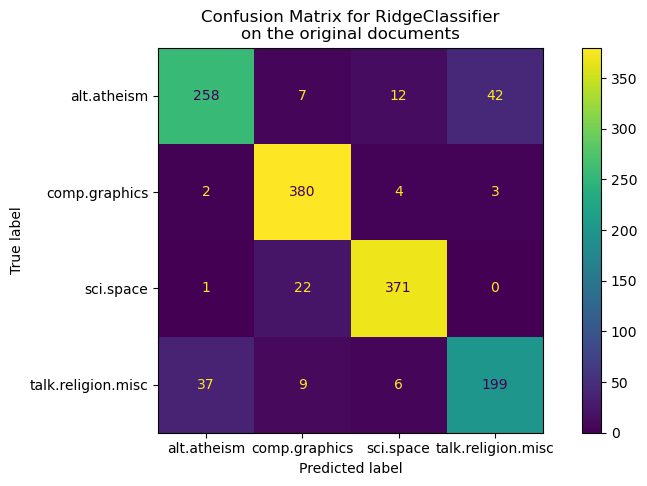

In [53]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

The confusion matrix highlights that documents of the `alt.atheism` class are often confused with documents with the class `talk.religion.misc` class and vice-versa which is expected since the topics are semantically related.

We also observe that some documents of the `sci.space` class can be misclassified as `comp.graphics` while the converse is much rarer. A manual inspection of those badly classified documents would be required to get some insights on this asymmetry. It could be the case that the vocabulary of the space topic could be more specific than the vocabulary for computer graphics.

We can gain a deeper understanding of how this classifier makes its decisions by looking at the words with the highest average feature effects:

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


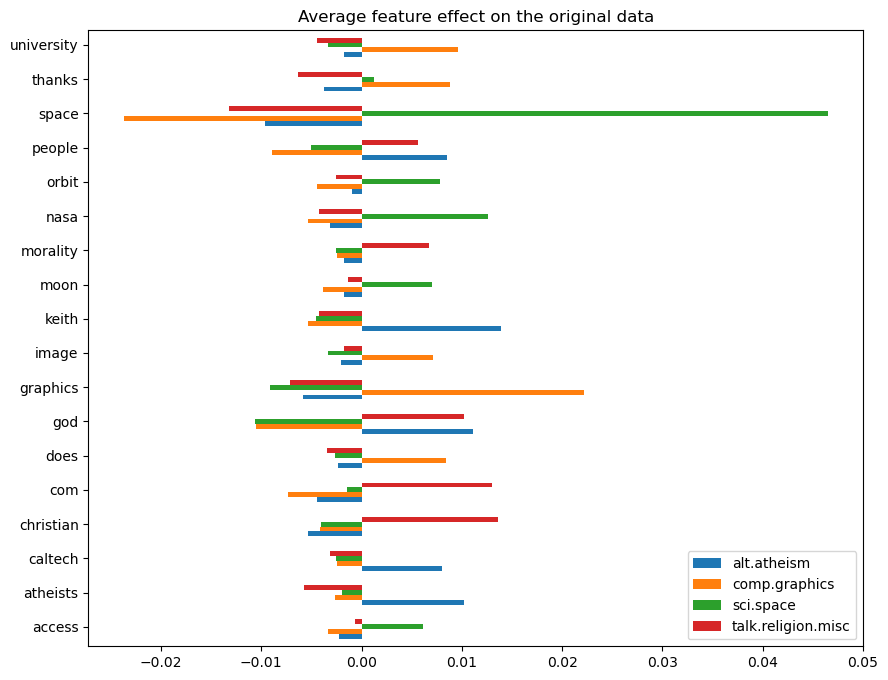

In [54]:
import numpy as np
import pandas as pd


def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")

We can observe that the most predictive words are often strongly positively associated with a single class and negatively associated with all the other classes. Most of those positive associations are quite easy to interpret. However, some words such as god" and "people" are positively associated to both "talk.misc.religion" and "alt.atheism" as those two classes expectedly share some common vocabulary. Notice however that there are also words such as "christian" and "morality" that are only positively associated with "talk.misc.religion". Furthermore, in this version of the dataset, the word "caltech" is one of the top predictive features for atheism due to pollution in the dataset coming from some sort of metadata such as the email addresses of the sender of previous emails in the discussion as can be seen below:

#### Benchmarking classifiers
Scikit-learn provides many different kinds of classification algorithms. In this section we will train a selection of those classifers on the same text classifiction problem and measure both their generalization and performance (accuracy on the test set) and their computation performance (speed), both at training time and testing time. For such purpose, we define the following benchmarking utilities:

In [55]:
from sklearn import metrics
from sklearn.utils.extmath import density


def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

We now train and test the datasets with 8 different classification models and get performance results for each model. The goal of this study is to highlight the computation/accuracy tradeoffs of different types of classifiers for such a multi-class text classification problem.

Notice that the most important hyperparameters values were tuned using a grid search procedure not shown in this notebook for the sake of simplicity.

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
train time: 0.712s
test time:  0.002s
accuracy:   0.892
dimensionality: 7831
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg')
train time: 0.0778s
test time:  0.000998s
accuracy:   0.893
dimensionality: 7831
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.000997s
test time:  4.43s
accuracy:   0.864

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 4.12s
test time:  0.0599s
accuracy:   0.834

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False)
tra

#### Plot accuracy, training and test time of each classifier
The scatter plots show the trade-off between the test accuracy and the training and testing time of each classifier

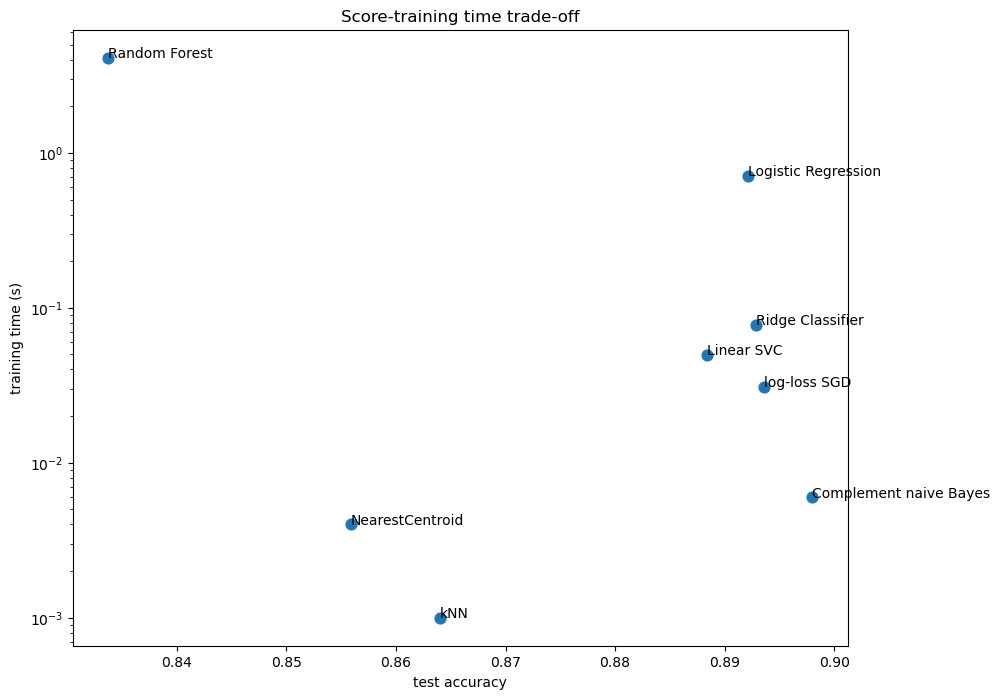

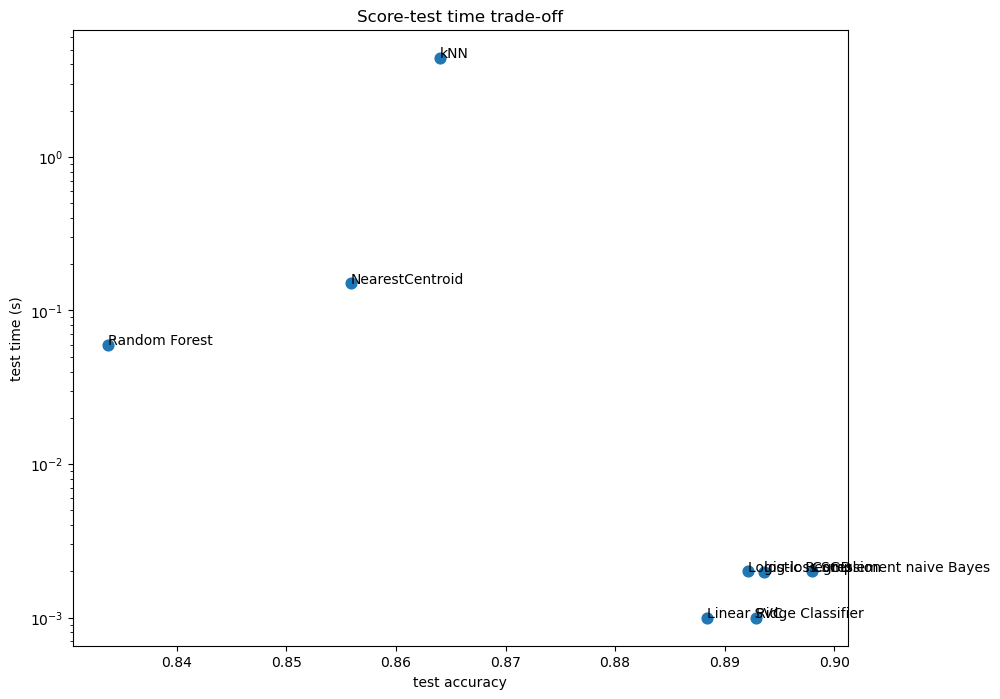

In [57]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(score, training_time, s=60)
ax1.set(
    title="Score-training time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="training time (s)",
)
fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(score, test_time, s=60)
ax2.set(
    title="Score-test time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)",
)

for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (score[i], training_time[i]))
    ax2.annotate(txt, (score[i], test_time[i]))

The naive Bayes model has the best trade-off between score and training/testing time, while Random Forest is both slow to train, expensive to predict and has a comparatively bad accuracy. This is expected: for high-dimensional prediction problems, linear models are often better suited as most problems become linearly separable when the feature space has 10,000 dimensions or more.

The difference in training speed and accuracy of the linear models can be explained by the choice of the loss function they optimize and the kind of regularization they use. Be aware that some linear models with the same loss but a different solver or regularization configuration may yield different fitting times and test accuracy. We can observe on the second plot that once trained, all linear models have approximately the same prediction speed which is expected because they all implement the same prediction function.

KNeighborsClassifier has a relatively low accuracy and has the highest testing time. The long prediction time is also expected: for each prediction the model has to compute the pairwise distances between the testing sample and each document in the training set, which is computationally expensive. Furthermore, the “curse of dimensionality” harms the ability of this model to yield competitive accuracy in the high dimensional feature space of text classification problems.